This script shows how to create fig2 from the main text

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.gridspec as gsp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats 
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))  
from scipy.special import gamma, factorial,digamma
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.special as sp 

In [3]:
# Experimental parameters
FLUORESCENCE_MAX=10**6
BINS=16
Partition=np.logspace(0,np.log10(FLUORESCENCE_MAX),BINS)
Part_conv=np.insert(Partition,0,0)
Mean_expression_bins=np.array([(Part_conv[j+1]+Part_conv[j])/2 for j in range(BINS)])

def data_transformation_bins(X):  #New representation of the data enabling the method of moments
    X=X.astype(int)
    T=np.repeat(Mean_expression_bins,X)
    return(T)

# Processing inference data

##  Loading and filtering data

In [4]:
df0=pd.read_csv('ICN_results_exp1-4_part0.csv')
df1=pd.read_csv('ICN_results_exp1-4_part1.csv')
df2=pd.read_csv('ICN_results_exp1-4_part2.csv')
df3=pd.read_csv('ICN_results_exp1-4_part3.csv')
df4=pd.read_csv('ICN_results_exp1-4_part4.csv')
df=pd.concat([df0,df1,df2,df3,df4], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244000 entries, 0 to 243999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   mu_MLE           244000 non-null  float64
 1   sigma_MLE        244000 non-null  float64
 2   mu_std           244000 non-null  float64
 3   sigma_std        244000 non-null  float64
 4   mu_MOM           244000 non-null  float64
 5   sigma_MOM        244000 non-null  float64
 6   Inference_grade  244000 non-null  float64
 7   Score            244000 non-null  float64
dtypes: float64(8)
memory usage: 14.9 MB


## Estimate $N^{(i)}$

In [5]:
Nj=(np.load('Nj_merged.npy')).astype(int) #FACS events in each bin ( Number of cells sorted in each bin)
Sij=np.load('Sij_merged.npy') #Filtered Read Counts for each genetic construct (one row) in each bin (one column)
READS=(np.array([ 1460332.,  2109815.,  2335533.,  3210865.,  4303324.,  5864139.,
        7490610.,  9922865., 12976416., 15188644., 19094267., 23689418.,
       23664179., 21895118., 17576043.,  5519053.])).astype(int)
Sij=Sij.astype(int)


##############################################################################################################
########################################  Auxiliary Values ###################################################

if np.any(READS==0):
    Enrich=Nj/(READS+0.001) 
    print('The number of reads allocated in one bin is suprisingly 0! are you sure?') 
else:
    Enrich=Nj/READS
Nijhat=np.multiply(Sij,Enrich)
Nihat=Nijhat.sum(axis=1)
Nihat=np.around(Nihat)
Nihat=Nihat.astype(int)

## Add sample size to the dataframe

In [6]:
df['Sample_size']=Nihat
df["Seq_depth"]=np.sum(Sij,axis=1)
df.head()

,mu_MLE,sigma_MLE,mu_std,sigma_std,mu_MOM,sigma_MOM,Inference_grade,Score,Sample_size,Seq_depth
0,8.140655,0.604394,0.021001,0.016022,8.144720,0.650836,1.0,0.0,682,981
1,8.864493,0.642694,0.019183,0.014412,8.864218,0.688124,1.0,0.0,900,1317
2,7.368765,0.806642,0.092066,0.068470,7.381271,0.876499,1.0,0.0,62,86
3,9.154152,0.727714,0.029489,0.021975,9.154239,0.768529,1.0,0.0,473,690
4,6.185709,0.617382,0.030325,0.023036,6.185966,0.664103,1.0,0.0,387,493


In [7]:
#Is ML inference worth it? keep only the sequences satisfying the following conditions:
df=df[df['Inference_grade']<2] # has the genetic construct been sequenced?
#df=df[df['Seq_depth']>100]  #has the construct been sufficiently sequenced?
df=df[(df['Score']<0.6) ] #Scoring of the data- How lopsided is the read count? We keep constructs only if less than 60% of the reads are not in the first or last bin ? (the binning induces a border effect that hinders inference)
df=df[df['mu_std']<0.1]
df=df[df['sigma_std']<0.1]
df=df[np.abs((df["mu_MLE"]-df["mu_MOM"])/df['mu_MLE'])<0.05]
df=df[np.abs((df["sigma_MLE"]-df["sigma_MOM"])/df['sigma_MLE'])<0.5]
print('We removed ',244000-len(df),' sequences after this inference quality check, accounting for ',100*(244000-len(df))/244000,'% of the original dataset')


We removed  14559  sequences after this inference quality check, accounting for  5.966803278688524 % of the original dataset


In [8]:
len(df)

229441

# Plotting data

## Finding the regime where the estimates are comparable

(0, 800)

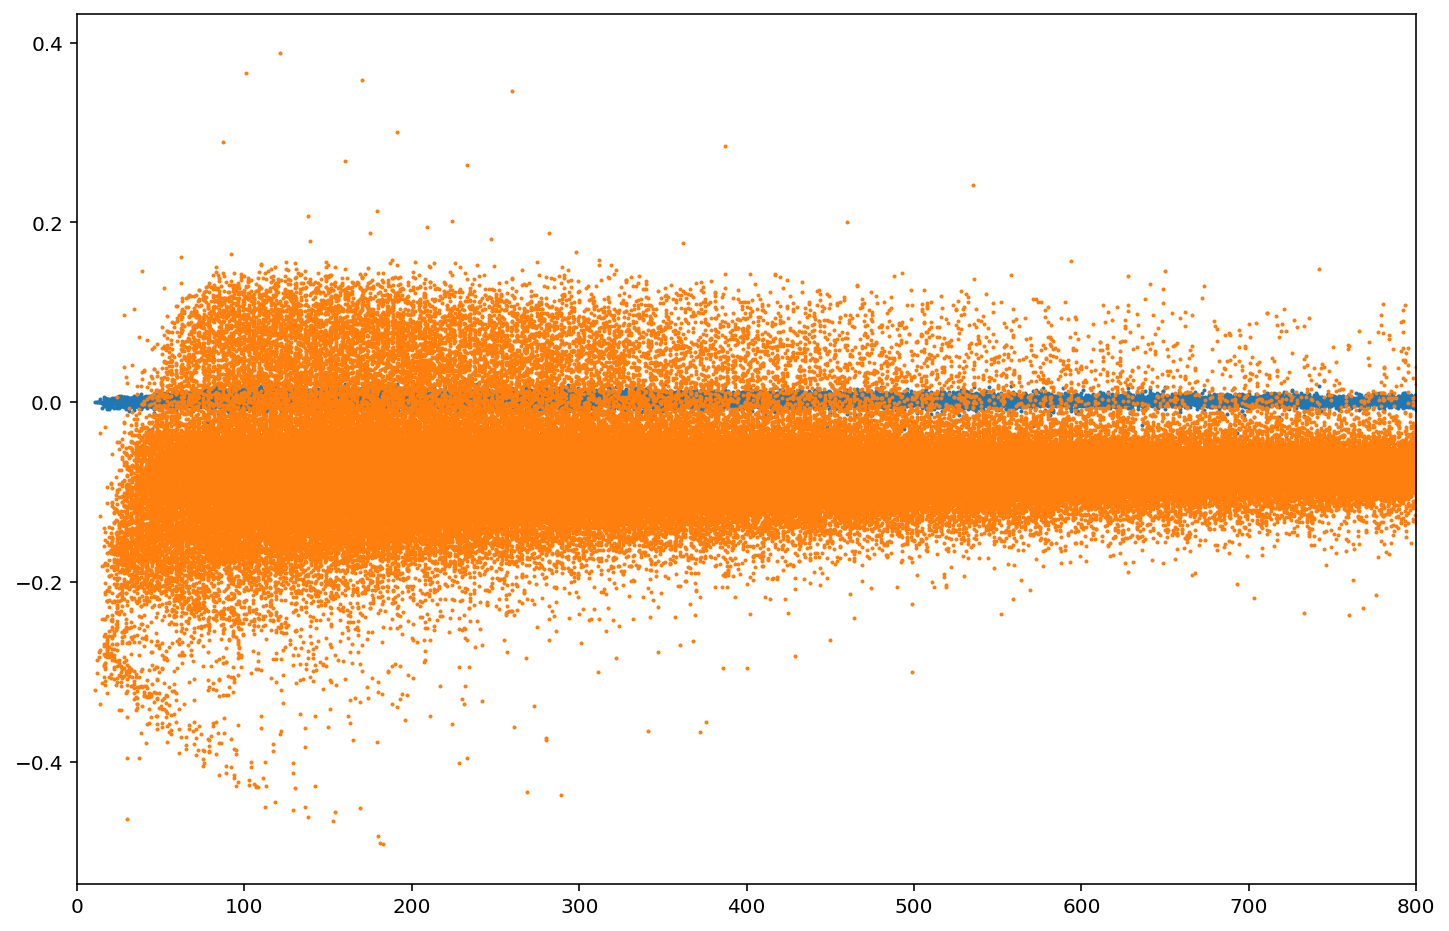

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x=df['Sample_size'],y=(df["mu_MLE"]-df["mu_MOM"])/df['mu_MLE'],s=1)
plt.scatter(x=df['Sample_size'],y=(df["sigma_MLE"]-df["sigma_MOM"])/df['sigma_MLE'],s=1)
plt.xlim(0, 800)


- Comparing different estimates on the mean protein copy number $\mu$

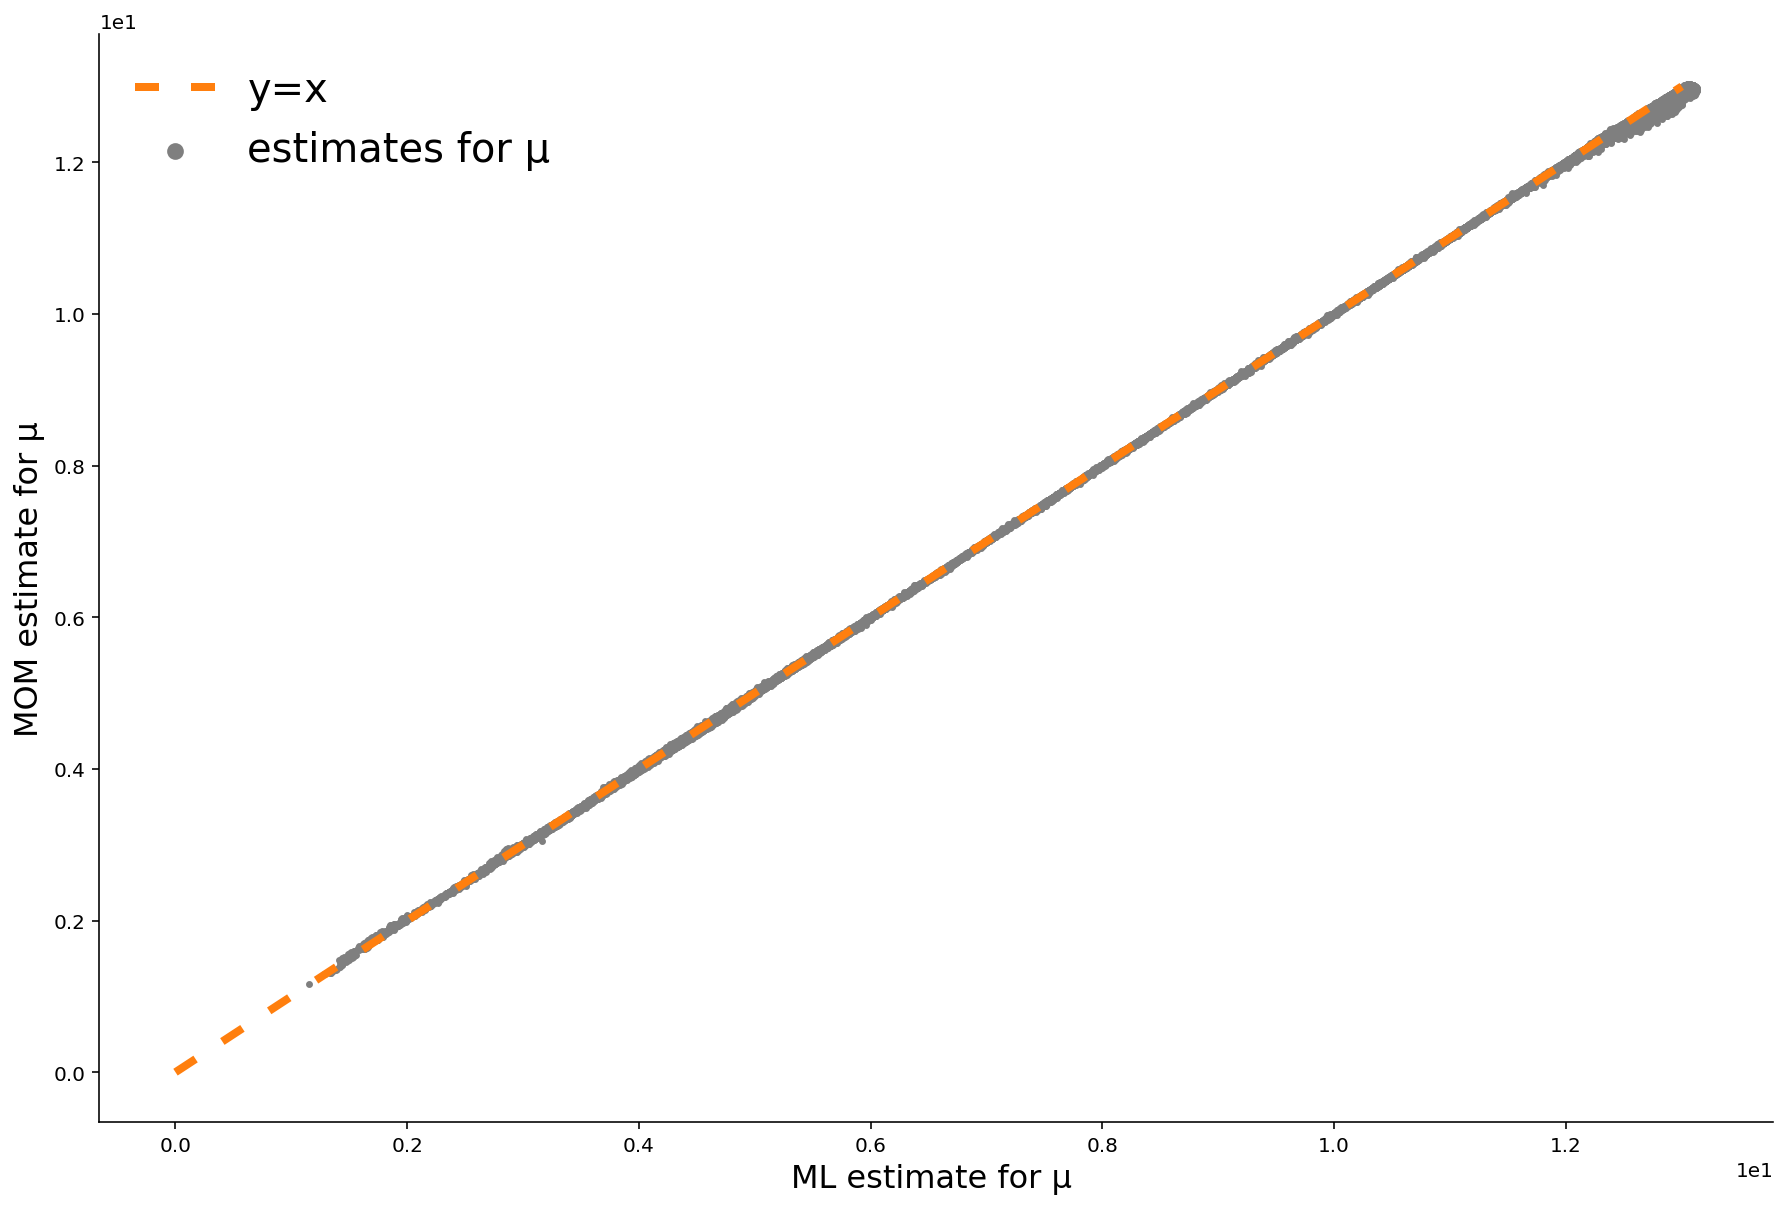

In [10]:
#Specifying two relevant genetic constructs
#i,j=972,12679
#ml1 =df.loc[[i]].values[0][4]
#mom1 =df.loc[[i]].values[0][10]
#ml2 =df.loc[[j]].values[0][4]
#mom2 =df.loc[[j]].values[0][10]
Z=np.linspace(0,13,1000)
X=df['mu_MLE']
Y=df['mu_MOM']
#X=np.exp(df['mu_MLE']+df['sigma_MLE']**2/2)
#Y=np.exp(df['mu_MOM']+df['sigma_MOM']**2/2)
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.scatter(X,Y,s=6,c='tab:grey',label='estimates for μ')
plt.plot(Z,Z,c='tab:orange',linewidth=4,label='y=x', linestyle='--',dashes=(3, 4),zorder=10)
plt.xlabel('ML estimate for μ ',fontsize=16)
plt.ylabel('MOM estimate for μ',fontsize=16)
sns.despine()
plt.legend(frameon=False,fontsize=20,markerscale=3)
plt.ticklabel_format(axis="x",style="sci", scilimits=(0,0))
plt.ticklabel_format( axis='y',style="sci", scilimits=(0,0))
#plt.plot(ml1, mom1, color='red', marker='o',markersize=9)
#plt.plot(ml2, mom2, color='red', marker='o',markersize=9)
#plt.savefig('Cambray_comparison_Ml_mom_4_experiments_merged_logfluorescence_data.png',transparent=True,bbox_inches='tight',dpi=600)

/opt/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


Text(0.005, 10000.0, '$ E(Z),std(Z) \\sim $ -5.e-04,2.e-03 ')

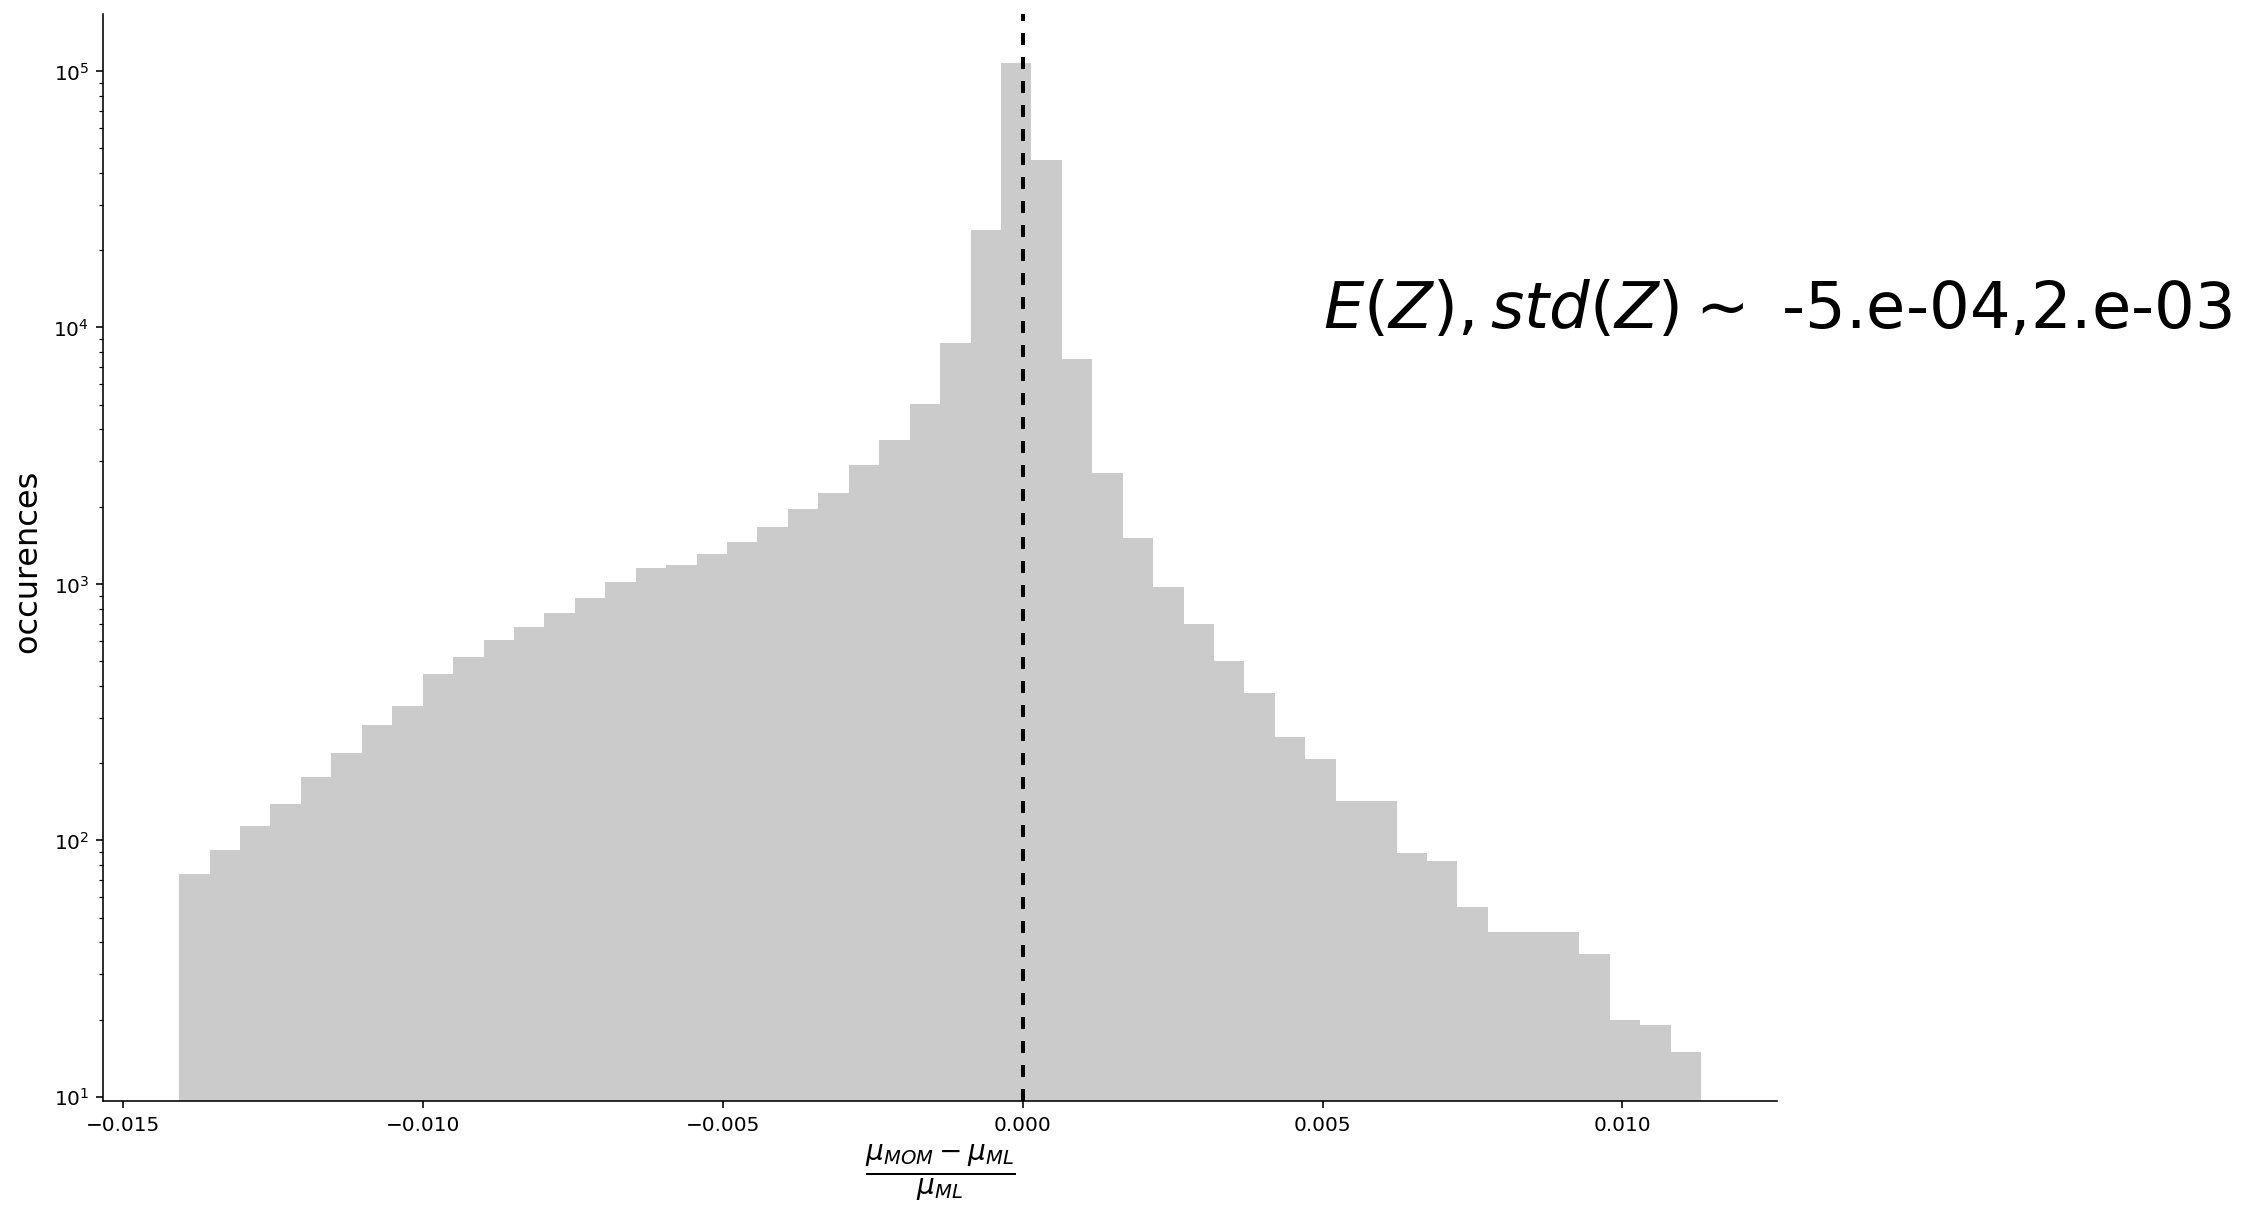

In [11]:
df_aux_mu=(Y-X)/X
df_aux_mu=df_aux_mu[df_aux_mu < df_aux_mu.quantile(.999)]
df_aux_mu=df_aux_mu[df_aux_mu > df_aux_mu.quantile(.001)]

plt.figure(figsize=(15,10))
sns.distplot(df_aux_mu,kde=False,color='tab:grey')
sns.despine()
plt.yscale('log')
plt.ylabel('occurences ',fontsize=16)
plt.xlabel(r'$\frac{\mu_{MOM}-\mu_{ML}}{\mu_{ML}} $',fontsize=20)
plt.axvline(x=0, ymin=0, ymax=1e5, c='black',linewidth=2, linestyle='--',dashes=(3,3 ))
approx_bias=np.format_float_scientific(np.mean(df_aux_mu),precision=0)
approx_variance=np.format_float_scientific(np.std(df_aux_mu,ddof=1),precision=0)
plt.text(0.005, 1e4, r'$ E(Z),std(Z) \sim $ %s,%s '%(approx_bias,approx_variance), fontsize=32)
#plt.savefig('Cambray_comparison_Ml_mom_4_experiments_merged_logfluorescence_data_distribution_upward_bias.png',transparent=True,bbox_inches='tight',dpi=600)

- Comparing estimates on the protein copy number variance $\sigma^{2}$

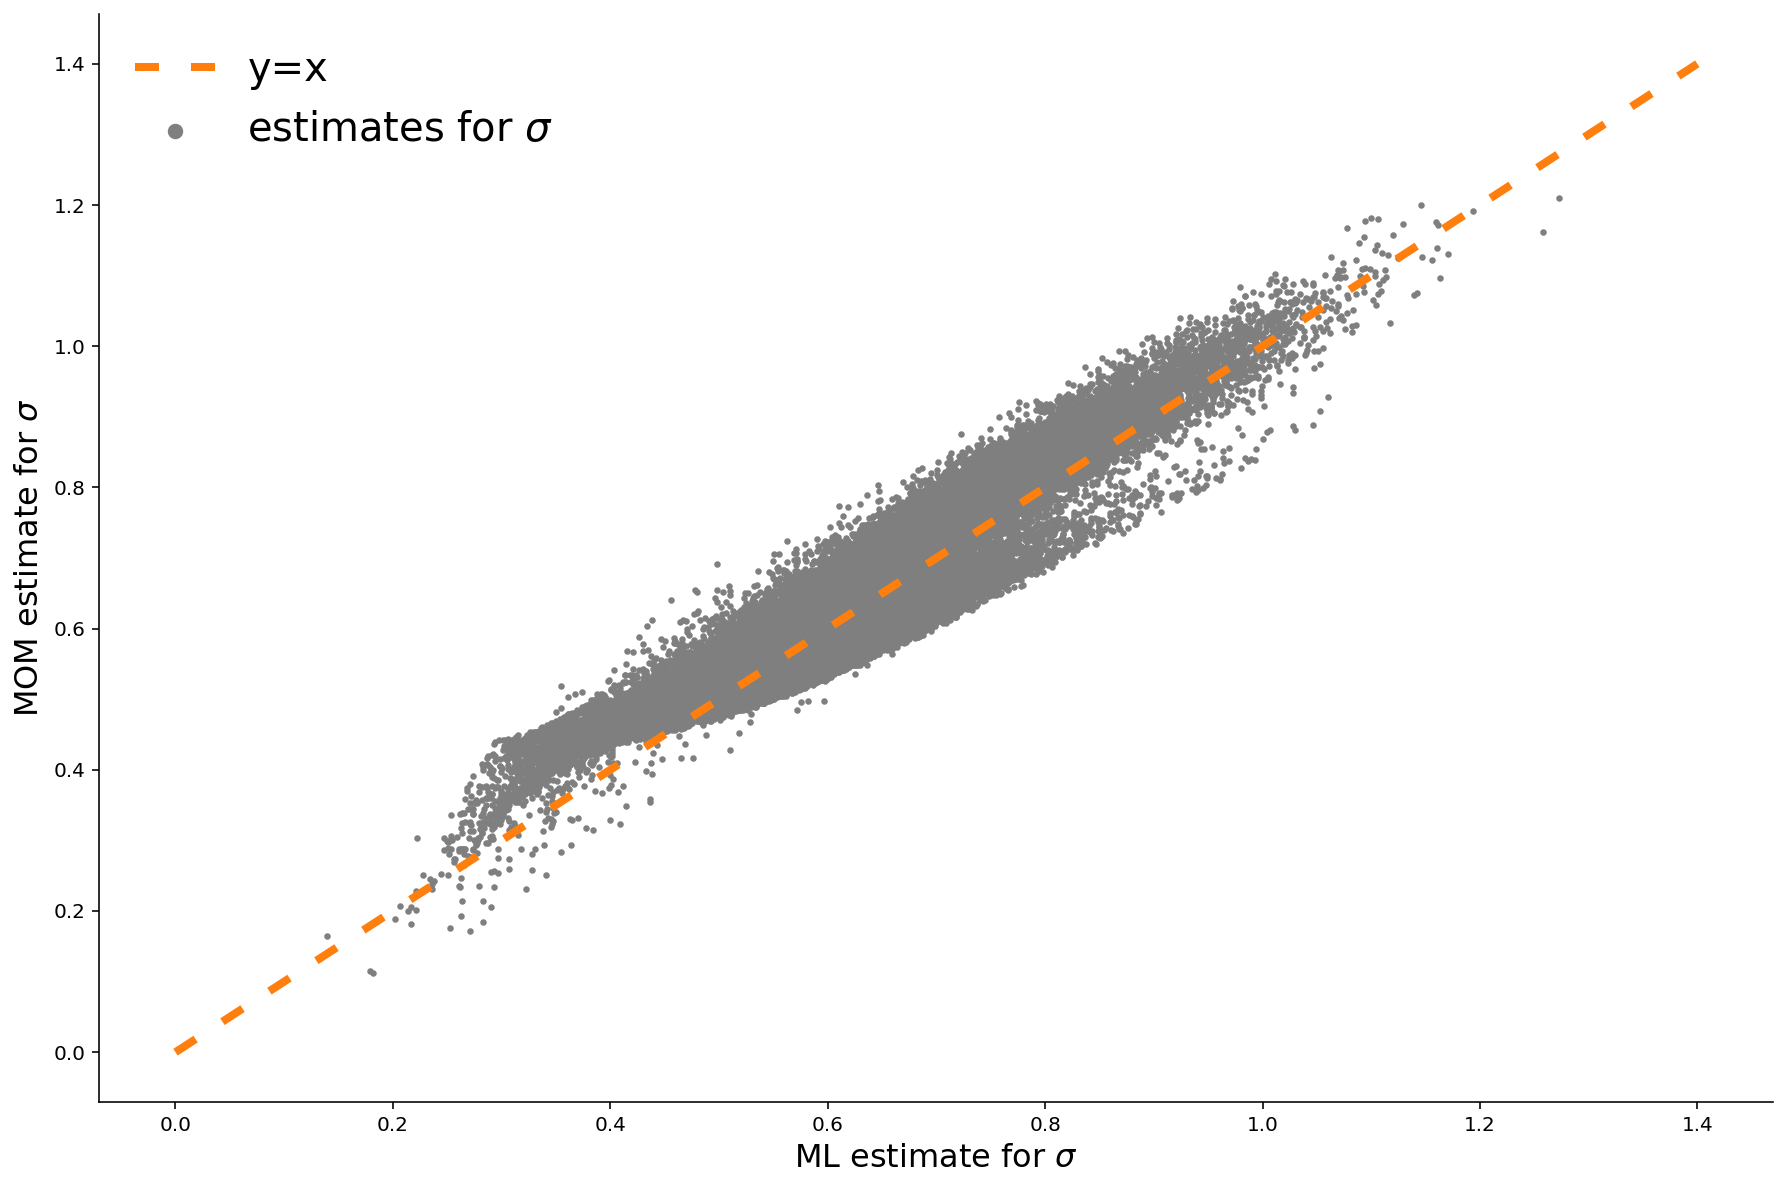

In [12]:
#Specifying two relevant genetic constructs
#i,j=972,12679
#ml1 =df.loc[[i]].values[0][5]
#mom1 =df.loc[[i]].values[0][11]
#ml2 =df.loc[[j]].values[0][5]
#mom2 =df.loc[[j]].values[0][11]

#X=np.exp(2*df['mu_MLE']+df['sigma_MLE']**2)*(np.exp(df['sigma_MLE']**2)-1)
#Y=np.exp(2*df['mu_MOM']+df['sigma_MOM']**2)*(np.exp(df['sigma_MOM']**2)-1)
X=df['sigma_MLE']
Y=df['sigma_MOM']
Z=np.linspace(0,1.4,1000)
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.scatter(X,Y,s=5,c='tab:grey',label='estimates for $\sigma$',)
plt.plot(Z,Z,c='tab:orange',linewidth=4,label='y=x', linestyle='--',dashes=(3, 4),zorder=10)
plt.xlabel('ML estimate for $\sigma$ ',fontsize=16)
plt.ylabel('MOM estimate for $\sigma$',fontsize=16)
sns.despine()
plt.legend(frameon=False ,fontsize=20,markerscale=3)
plt.ticklabel_format(axis="x",style="sci", scilimits=(0,0))
plt.ticklabel_format( axis='y',style="sci", scilimits=(0,0))
#plt.plot(ml1, mom1, color='red', marker='o',markersize=9)
#plt.plot(ml2, mom2, color='red', marker='o',markersize=9)
#plt.savefig('Cambray_comparison_Ml_mom_4_experiments_variance_log_fluorescence_data.png',transparent=True,bbox_inches='tight',dpi=600)

/opt/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


Text(0.1, 10000.0, '$ E(Z),V(Z) \\sim $ 7.e-02,4.e-02 ')

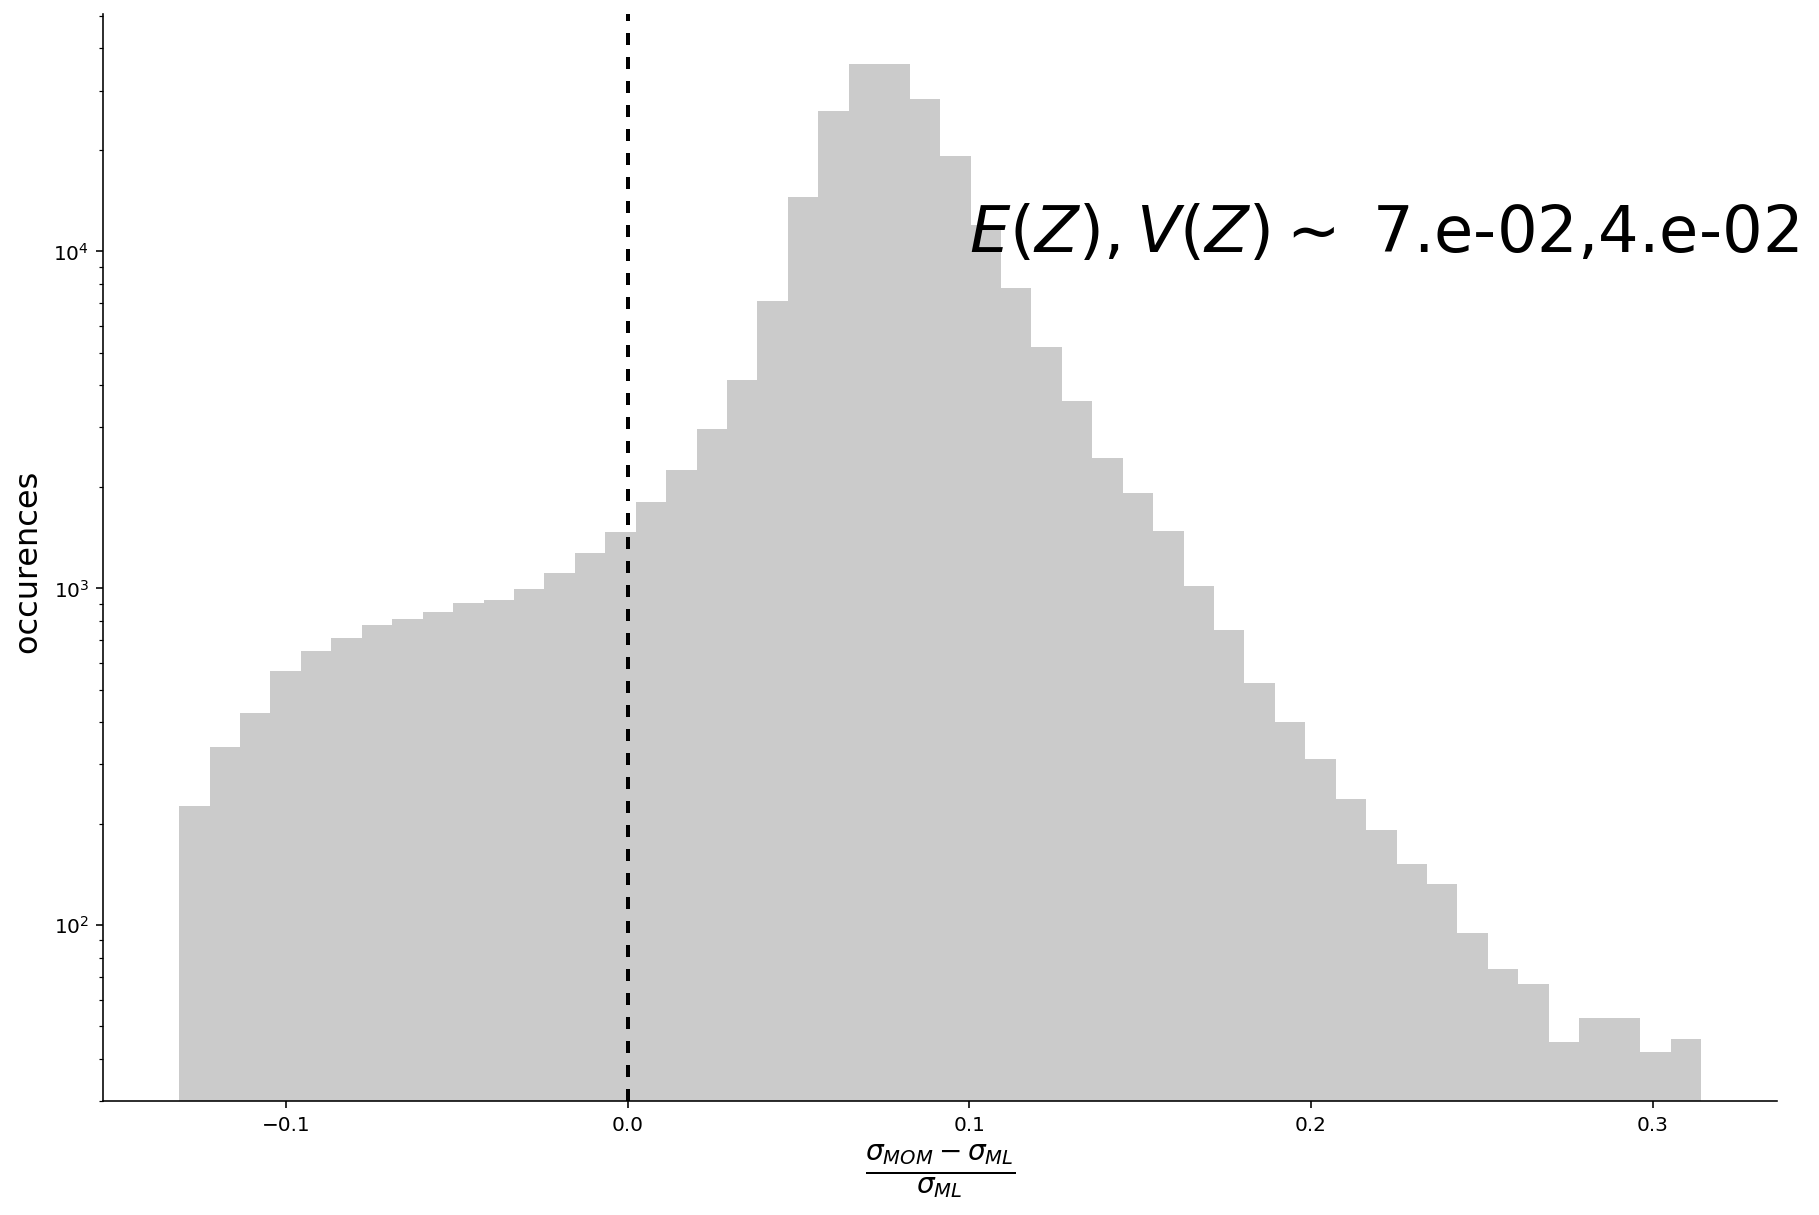

In [13]:
df_aux_var=(Y-X)/X
df_aux_var=df_aux_var[df_aux_var < df_aux_var.quantile(.999)]
df_aux_var=df_aux_var[df_aux_var > df_aux_var.quantile(.001)]


plt.figure(figsize=(15,10))
sns.distplot(df_aux_var,kde=False,color='tab:grey')
sns.despine()
plt.yscale('log')
plt.ylabel('occurences ',fontsize=16)
plt.xlabel(r'$ \frac{\sigma_{MOM}-\sigma_{ML}}{\sigma_{ML}}$',fontsize=20)
plt.axvline(x=0, ymin=0, ymax=1e5, c='black',linewidth=2, linestyle='--',dashes=(3,3 ))
approx_bias=np.format_float_scientific(np.mean(df_aux_var),precision=0)
approx_variance=np.format_float_scientific(np.std(df_aux_var,ddof=1),precision=0)
plt.text(0.1, 1e4, r'$ E(Z),V(Z) \sim $ %s,%s '%(approx_bias,approx_variance), fontsize=32)
#plt.savefig('Cambray_comparison_Ml_mom_4_experiments_merged_logfluorescence_data_distribution_upward_bias_variance.png',transparent=True,bbox_inches='tight',dpi=600)

- Visualising the two reconstructions: 

8.287869194325804 0.4612522254025584 8.286453615535633 0.5033001259728351


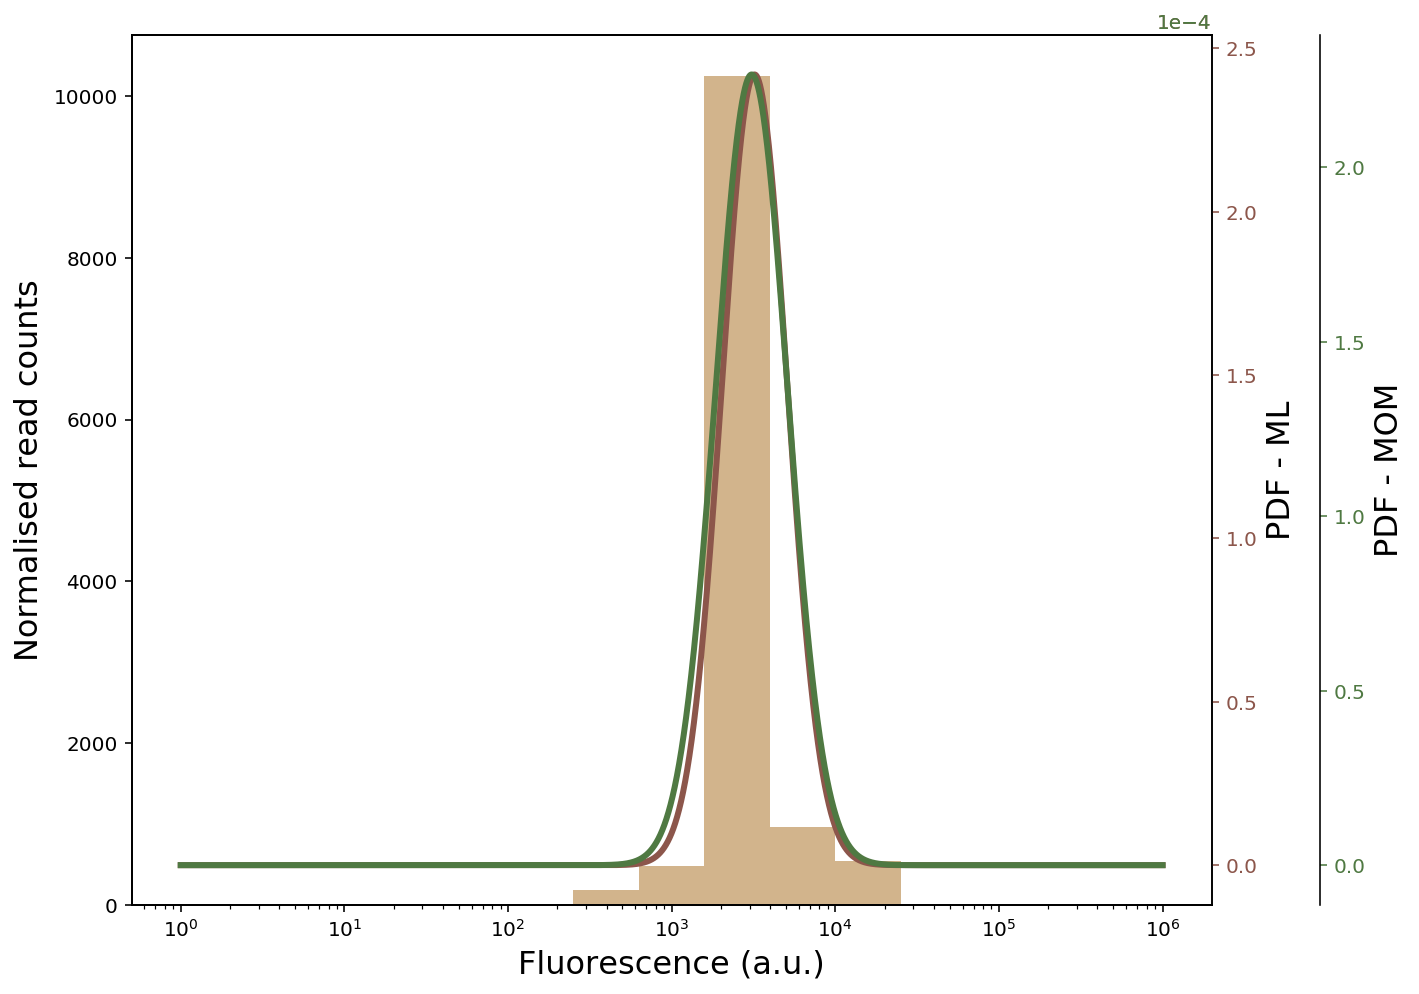

In [22]:
#Interesting constructs to choose from
#i=972
i=7205
#i=28
#i=38539
i=178530
i=136132
x = np.linspace(1, 1e6, 5000000)
a =df.loc[[i]].values[0][0]
b =df.loc[[i]].values[0][1]
a2 = df.loc[[i]].values[0][4]
b2= df.loc[[i]].values[0][5]

#Data
y_mle =stats.lognorm.pdf(x, s=b, scale=np.exp(a)) # the normal pdf
y_mom=stats.lognorm.pdf(x, s=b2, scale=np.exp(a2))

#Graph
fig, ax = plt.subplots(figsize=(12,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)
# And finally we get to plot things...
colors = ('tan','tab:brown', '#4f7942')
axes[0].hist(data_transformation_bins(Nijhat[i,:]),bins=Partition,zorder=0,color='tan',label='Read count')
axes[1].plot(x, y_mle, label='ML reconstruction',linewidth=3,zorder=5,color='tab:brown')
axes[2].plot(x, y_mom, label='MOM reconstruction',linewidth=3,zorder=3,c='#4f7942')

axes[0].set_ylabel('Normalised read counts',fontsize=16)
axes[1].set_ylabel('PDF - ML',fontsize=16)
axes[2].set_ylabel('PDF - MOM',fontsize=16)
#axes[0].tick_params(axis='y', colors=color)
axes[1].tick_params(axis='y', colors=colors[1])
axes[2].tick_params(axis='y', colors=colors[2])
axes[0].set_xlabel('Fluorescence (a.u.)',fontsize=16)
axes[1].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
axes[2].ticklabel_format(axis="y",style="sci", scilimits=(0,0))
plt.xscale('log')
print(a,b,a2,b2)
#plt.savefig('Comparison real datasetmom-mle-construct12679.png',transparent=True,bbox_inches='tight',dpi=600)
#plt.close()

## Uncertainty as a function of sample size

In [15]:
df.sort_values(by='Sample_size',ascending=False)
#df=df[df['Sample_size']<1500]

,mu_MLE,sigma_MLE,mu_std,sigma_std,mu_MOM,sigma_MOM,Inference_grade,Score,Sample_size,Seq_depth
136132,8.287869,0.461252,0.003959,0.002813,8.286454,0.503300,1.0,0.000000,12411,17897
13360,3.852461,0.748303,0.011009,0.008138,3.849469,0.780352,1.0,0.000000,7191,5520
133387,3.408539,0.802732,0.012475,0.009011,3.393921,0.840563,1.0,0.000000,7029,4590
132605,3.543964,0.730401,0.011315,0.008260,3.535611,0.791162,1.0,0.000000,6999,4800
133576,3.682057,0.690522,0.010748,0.007928,3.682607,0.730352,1.0,0.000000,6831,4911
...,...,...,...,...,...,...,...,...,...,...
30532,12.523961,0.265093,0.091499,0.053088,12.520306,0.338681,1.0,0.071429,13,20
86177,9.930587,0.263917,0.090817,0.052700,9.929898,0.338681,1.0,0.000000,13,19
36773,11.655908,0.270832,0.094844,0.056095,11.656837,0.352510,1.0,0.000000,12,18
94848,12.524334,0.273875,0.096655,0.057543,12.520306,0.352510,1.0,0.076923,12,18


- According to likelihood theory, we should expect $\mathbb{E}[6se(\hat{\mu},\hat{\sigma})|s]=\frac{\kappa}{ \sqrt{s}} $

With $CI$ being the length of the confidence interval (uncertainty) associated with the point estimate (mean or variance). With 6 * CI, we know that approximately 99.7% of the estimates will be in the in this interval.

We will perform RAMSAC regression (Robust regression)  to find $\kappa$ for $\mu$ and $\sigma$.

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

##########   Regression for CI_mu=f(sample_size)  #############
X, y=(np.log(df['Sample_size'].values)).reshape(-1, 1), np.log(6*df['mu_std'].values)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor(min_samples=50, max_trials=100000000)
ransac.fit(X,y)
alpha_mu,kappa_mu= ransac.estimator_.coef_,ransac.estimator_.intercept_

##########   Regression for CI_mu=f(sample_size)  #############
X, y=(np.log(df['Sample_size'].values)).reshape(-1, 1), np.log(6*df['sigma_std'].values)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor(min_samples=50, max_trials=100000000)
ransac.fit(X,y)
alpha_sigma,kappa_sigma= ransac.estimator_.coef_,ransac.estimator_.intercept_


In [28]:

alpha_mu,kappa_mu,alpha_sigma,kappa_sigma

(array([-0.46927578]),
 1.0219031405282109,
 array([-0.49271003]),
 0.9062946359764235)

$\frac{1.02}{s^{0.47}}$

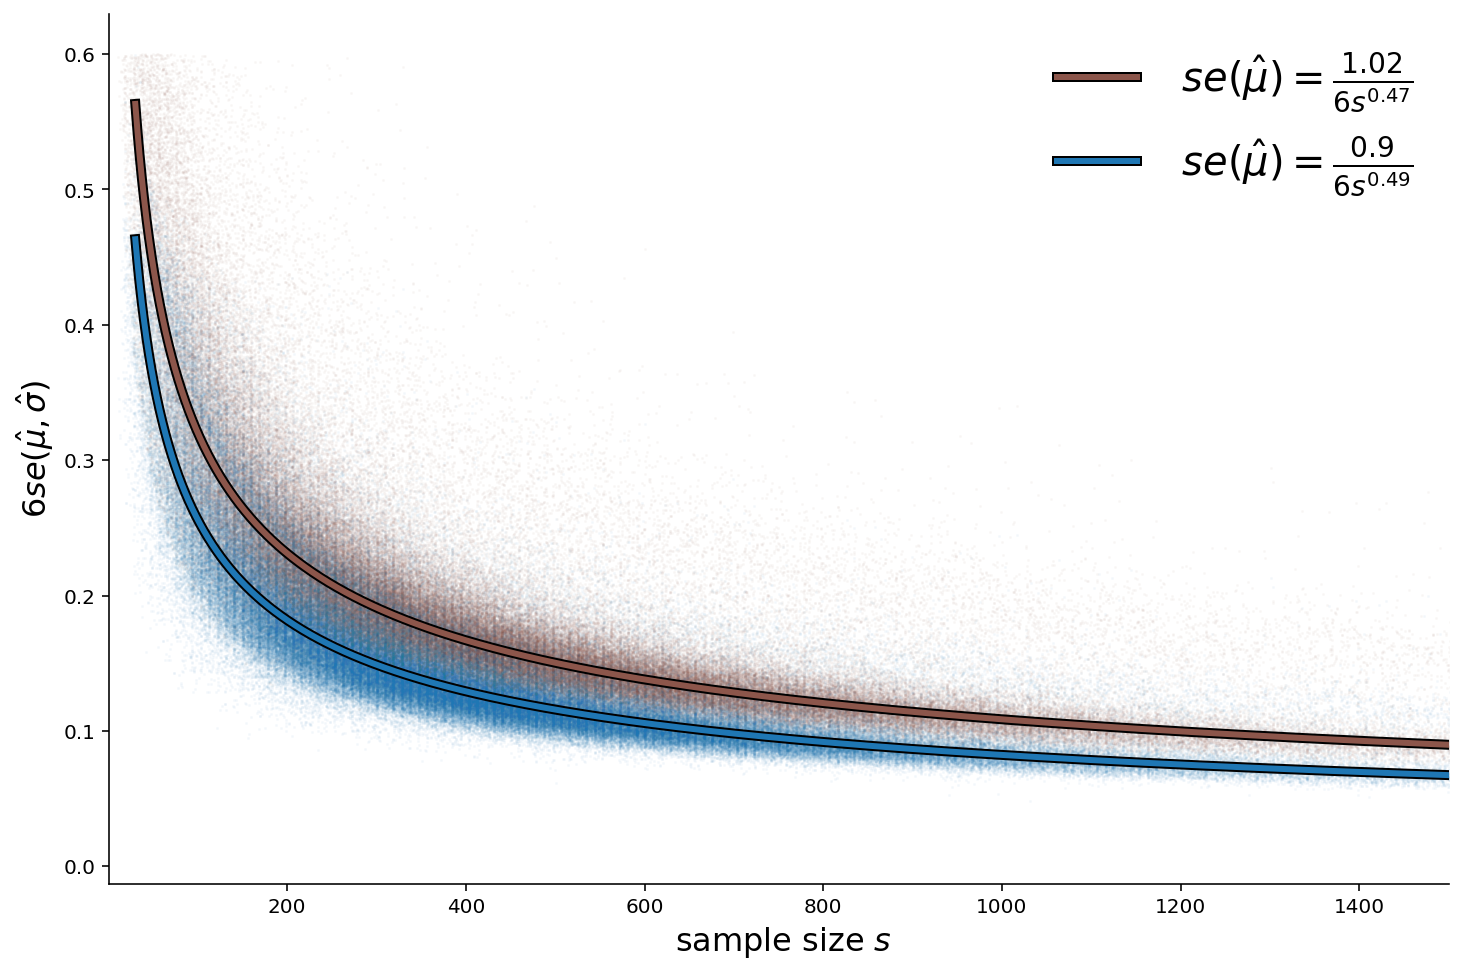

In [41]:
import matplotlib.patheffects as pe 
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x=df['Sample_size'],y=6*df["mu_std"],s=0.3,alpha=0.04,color='tab:brown')
plt.scatter(x=df['Sample_size'],y=6*df["sigma_std"],s=0.3,alpha=0.04,color='tab:blue')
plt.plot(np.linspace(30,2000,10000),np.exp( kappa_mu)*(np.linspace(30,2000,10000)**(alpha_mu)),color='tab:brown',lw=3,path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()],label=r' $se(\hat{\mu})=\frac{1.02}{6s^{0.47}} $' )
plt.plot(np.linspace(30,2000,10000),np.exp(  kappa_sigma)*(np.linspace(30,2000,10000)**(alpha_sigma)),color='tab:blue',lw=3,path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()],label=r' $se(\hat{\mu})=\frac{0.9}{6s^{0.49}} $'  )
plt.xlabel(' sample size $s$ ',fontsize=16)
plt.ylabel(r'$6se(\hat{\mu},\hat{\sigma})$',fontsize=16)
plt.xlim(1, 1500)
sns.despine()
plt.legend(frameon=False ,fontsize=20,markerscale=3)
plt.show()
#$\mathbb{E}[6se(\hat{\mu},\hat{\sigma})|s]=\frac{1}{\kappa \sqrt{s}} $


In [18]:
df['ss_coarse']=df.apply(lambda row: np.format_float_scientific(row['Sample_size'],precision=int(np.log10(row['Sample_size']))-1),axis=1)

In [19]:
df.groupby(['ss_coarse']).mean()['mu_std']

ss_coarse
1.00e+03    0.019444
1.01e+03    0.019247
1.02e+03    0.019023
1.03e+03    0.019517
1.04e+03    0.019260
              ...   
9.7e+02     0.019909
9.8e+02     0.019561
9.9e+02     0.019684
9.e+01      0.060123
9.e+02      0.020242
Name: mu_std, Length: 511, dtype: float64

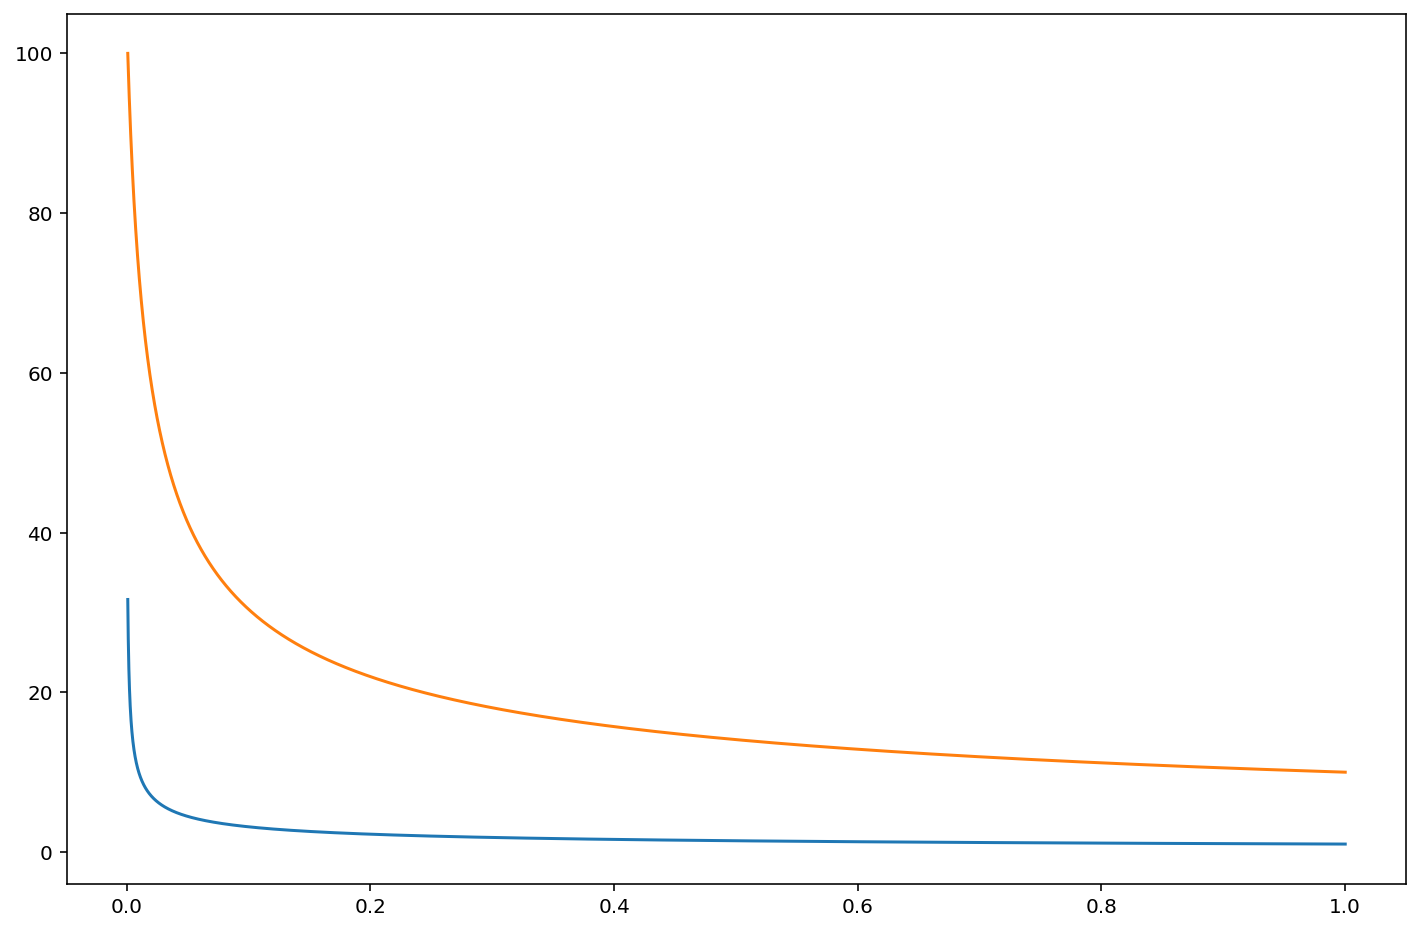

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.linspace(0.001,1,10000),(np.linspace(0.001,1,10000))**(-1/2))
plt.plot(np.linspace(0.001,1,10000),(0.01*np.linspace(0.01,1,10000))**(-1/2))

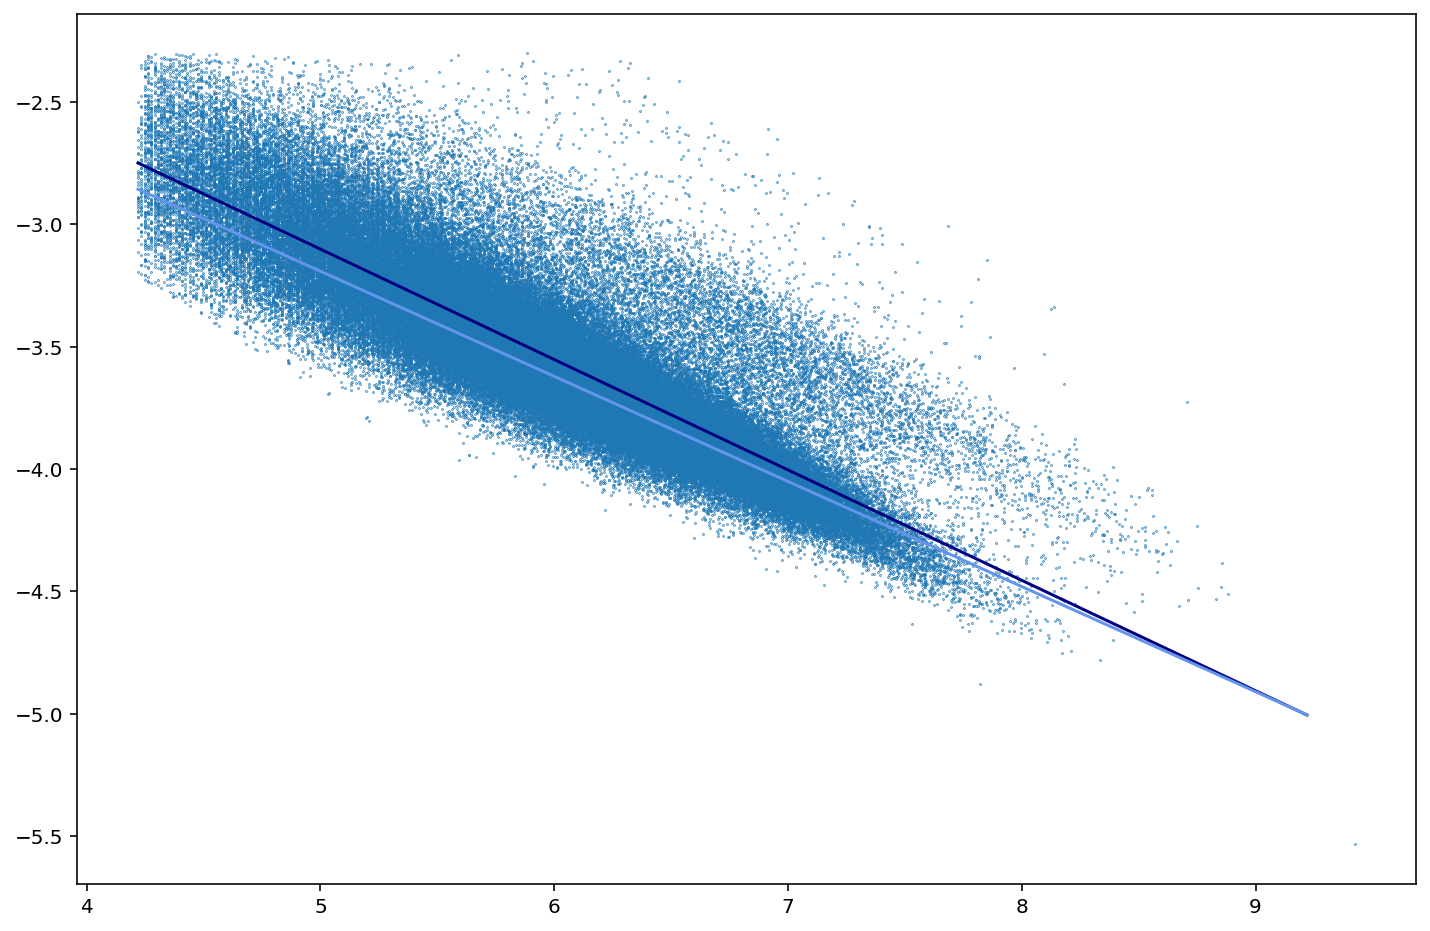

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(np.log(df['Sample_size']),np.log(df['mu_std']),s=0.1)
plt.plot(line_X, line_y, color='navy', label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue',
         label='RANSAC regressor')

In [110]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

X, y=(np.log(df['Sample_size'].values)).reshape(-1, 1), np.log(df['sigma_std'].values)
# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X,y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor(min_samples=50, max_trials=100000000)
ransac.fit(X,y)
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print( lr.coef_, ransac.estimator_.coef_,ransac.estimator_.intercept_)

Estimated coefficients (true, linear regression, RANSAC):
[-0.47960197] [-0.49531618] -0.8698458827760334


In [82]:
np.exp(-0.7596367802246209)

0.4678363235575052